In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import networkx as nx
import itertools
import pandas as pd
import numpy as np
from stellargraph import StellarGraph
from rdkit.Chem import AllChem, DataStructs
import json
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow import keras
import tensorflow as tf

import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import HinSAGELinkGenerator
from stellargraph.layer import HinSAGE, link_classification
from tensorflow.keras import Model, optimizers, losses, metrics

import multiprocessing
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from tensorflow.keras import mixed_precision

In [2]:
g = nx.read_graphml("./graph/train_graph.gml")
species_features_dummy = pd.read_csv("./data/species_features.csv.gz", index_col=0).astype('uint8')
molecule_features_dummy = pd.read_csv("./data/molecule_features.csv.gz", index_col=0).astype("uint8")
df_agg = pd.read_csv("./data/lotus_agg_train.csv.gz", index_col=0)

In [3]:
rdkit = pd.read_csv("./data/mol_dummy_rdkit.csv.gz", index_col=0).astype('int8')
molecule_features_dummy = molecule_features_dummy.merge(rdkit,
                                                        left_index=True,
                                                        right_index=True)

In [4]:
species_test = species_features_dummy[~species_features_dummy.index.isin(df_agg.organism_name)].index
mol_test = molecule_features_dummy[~molecule_features_dummy.index.isin(df_agg.structure_smiles_2D)].index

In [5]:
species_feat = species_features_dummy[species_features_dummy.index.isin(df_agg.organism_name)]
molecule_feat = molecule_features_dummy[molecule_features_dummy.index.isin(df_agg.structure_smiles_2D)]

In [6]:
G = StellarGraph.from_networkx(g,
                               node_features={'species':species_feat,
                                              'molecule': molecule_feat},
                              dtype='uint8')
print(G.info())
G.check_graph_for_ml()

StellarDiGraph: Directed multigraph
 Nodes: 149619, Edges: 608638

 Node types:
  molecule: [115568]
    Features: uint8 vector, length 1051
    Edge types: molecule-present_in->species
  species: [34051]
    Features: uint8 vector, length 69
    Edge types: species-has->molecule

 Edge types:
    species-has->molecule: [304319]
        Weights: all 1 (default)
        Features: none
    molecule-present_in->species: [304319]
        Weights: all 1 (default)
        Features: none


In [7]:
batch_size = 128 #default: 200
epochs = 30 #default: 20
num_samples = [3, 1]
num_workers = multiprocessing.cpu_count()-2

In [8]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(G)

# Randomly sample a fraction p=0.3 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=False, edge_label="has"
)

Network has 304319 edges of type has
Network has 304319 edges of type has
** Sampled 30431 positive and 30431 negative edges. **


In [9]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.3 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=False, edge_label="has"
)

Network has 273888 edges of type has
Network has 273888 edges of type has
** Sampled 27388 positive and 27388 negative edges. **


In [10]:
print(G_train.info())

StellarDiGraph: Directed multigraph
 Nodes: 149619, Edges: 550819

 Node types:
  molecule: [115568]
    Features: float32 vector, length 1051
    Edge types: molecule-present_in->species
  species: [34051]
    Features: float32 vector, length 69
    Edge types: species-has->molecule

 Edge types:
    molecule-present_in->species: [304319]
        Weights: all 1 (default)
        Features: none
    species-has->molecule: [246500]
        Weights: all 1 (default)
        Features: none


In [11]:
print(G_test.info())

StellarDiGraph: Directed multigraph
 Nodes: 149619, Edges: 578207

 Node types:
  molecule: [115568]
    Features: float32 vector, length 1051
    Edge types: molecule-present_in->species
  species: [34051]
    Features: float32 vector, length 69
    Edge types: species-has->molecule

 Edge types:
    molecule-present_in->species: [304319]
        Weights: all 1 (default)
        Features: none
    species-has->molecule: [273888]
        Weights: all 1 (default)
        Features: none


In [12]:
train_gen = HinSAGELinkGenerator(G_train,
                                 batch_size=batch_size,
                                 num_samples=num_samples,
                                 head_node_types=["species", "molecule"],
                                seed=42)
train_flow = train_gen.flow(edge_ids_train, edge_labels_train, shuffle=True, seed=42)

In [13]:
test_gen = HinSAGELinkGenerator(G_test,
                                batch_size=batch_size,
                                num_samples=num_samples,
                                head_node_types=["species", "molecule"],
                               seed=42)
test_flow = test_gen.flow(edge_ids_test, edge_labels_test, seed=42)

In [14]:
hinsage_layer_sizes = [1024, 1024]
hinsage = HinSAGE(layer_sizes=hinsage_layer_sizes,
                  generator=train_gen,
                  bias=True,
                  dropout=0.3,
                 activations=['elu','selu'])

In [15]:
# Build the model and expose input and output sockets of graphsage model
# for link prediction
x_inp, x_out = hinsage.in_out_tensors()

/usr/local/Caskroom/mambaforge/base/envs/stellargraph/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [16]:
prediction = link_classification(output_dim=1,
                                 output_act="sigmoid",
                                 edge_embedding_method="l1")(x_out)

link_classification: using 'l1' method to combine node embeddings into edge embeddings


In [17]:
model = keras.Model(inputs=x_inp, outputs=prediction)

initial_learning_rate = 0.1
final_learning_rate = 0.001
learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/epochs)
steps_per_epoch = int(edge_ids_train.shape[0]/batch_size)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)

optimizer=keras.optimizers.Adam(learning_rate=lr_schedule)
#optimizer = mixed_precision.LossScaleOptimizer(optimizer)

model.compile(
    optimizer=optimizer,
    loss=keras.losses.binary_crossentropy,
    metrics=["AUC"],
)

In [18]:
init_train_metrics = model.evaluate(train_flow, workers=num_workers, verbose=2)
init_test_metrics = model.evaluate(test_flow, workers=num_workers, verbose=2)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

428/428 - 10s - loss: 0.6932 - auc: 0.5085 - 10s/epoch - 23ms/step
476/476 - 13s - loss: 0.6931 - auc: 0.5113 - 13s/epoch - 28ms/step

Train Set Metrics of the initial (untrained) model:
	loss: 0.6932
	auc: 0.5085

Test Set Metrics of the initial (untrained) model:
	loss: 0.6931
	auc: 0.5113


In [19]:
callbacks = keras.callbacks.EarlyStopping(monitor="val_loss",
                                          patience=5,
                                          mode="auto",
                                          restore_best_weights=True)

history = model.fit(train_flow,
                    epochs=epochs,
                    workers=num_workers,
                    validation_data=test_flow,
                    verbose=2,
                    callbacks=[callbacks],
                    validation_split=0.0,
                    shuffle=True
                   )

Epoch 1/30
428/428 - 46s - loss: 0.5231 - auc: 0.8081 - val_loss: 0.3510 - val_auc: 0.9230 - 46s/epoch - 108ms/step
Epoch 2/30
428/428 - 42s - loss: 0.3396 - auc: 0.9278 - val_loss: 0.2936 - val_auc: 0.9495 - 42s/epoch - 99ms/step
Epoch 3/30
428/428 - 42s - loss: 0.2803 - auc: 0.9510 - val_loss: 0.2462 - val_auc: 0.9626 - 42s/epoch - 97ms/step
Epoch 4/30
428/428 - 42s - loss: 0.2411 - auc: 0.9637 - val_loss: 0.2345 - val_auc: 0.9711 - 42s/epoch - 99ms/step
Epoch 5/30
428/428 - 47s - loss: 0.2081 - auc: 0.9728 - val_loss: 0.2008 - val_auc: 0.9749 - 47s/epoch - 111ms/step
Epoch 6/30
428/428 - 43s - loss: 0.1812 - auc: 0.9793 - val_loss: 0.1902 - val_auc: 0.9777 - 43s/epoch - 101ms/step
Epoch 7/30
428/428 - 37s - loss: 0.1643 - auc: 0.9827 - val_loss: 0.1818 - val_auc: 0.9795 - 37s/epoch - 87ms/step
Epoch 8/30
428/428 - 50s - loss: 0.1498 - auc: 0.9855 - val_loss: 0.1769 - val_auc: 0.9807 - 50s/epoch - 116ms/step
Epoch 9/30
428/428 - 41s - loss: 0.1391 - auc: 0.9873 - val_loss: 0.1726 - v

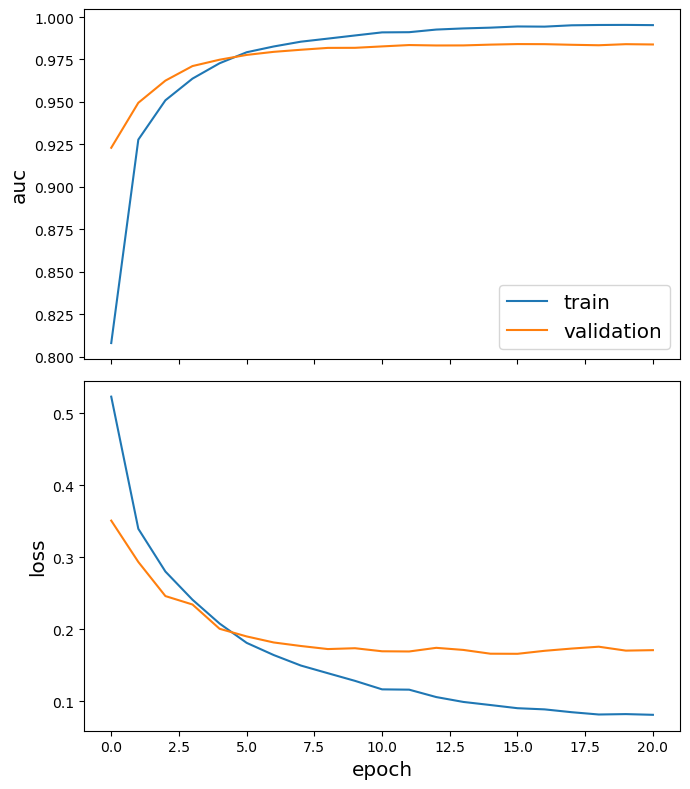

In [20]:
sg.utils.plot_history(history)

In [21]:
train_metrics = model.evaluate(train_flow, verbose=2)
test_metrics = model.evaluate(test_flow, verbose=2)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

428/428 - 10s - loss: 0.0457 - auc: 0.9984 - 10s/epoch - 24ms/step
476/476 - 9s - loss: 0.1686 - auc: 0.9836 - 9s/epoch - 20ms/step

Train Set Metrics of the trained model:
	loss: 0.0457
	auc: 0.9984

Test Set Metrics of the trained model:
	loss: 0.1686
	auc: 0.9836


In [22]:
def predict(model, flow, iterations=10):
    predictions = []
    for _ in range(iterations):
        predictions.append(model.predict(flow, workers=-1).flatten())

    return np.mean(predictions, axis=0)

In [23]:
test_pred = HinSAGELinkGenerator(G,
                                 batch_size=batch_size,
                                num_samples=num_samples,
                                head_node_types=["species", "molecule"],
                                seed=42).flow(edge_ids_test, edge_labels_test, seed=42)

In [24]:
predictions = predict(model, test_pred)

476/476 [==============================] - 10s 21ms/step


In [25]:
middle = int(len(predictions)/2)

In [26]:
np.mean(predictions[:middle])

0.9518543

In [27]:
np.mean(predictions[middle:])

0.07954528

In [28]:
test = predictions[(predictions>0.5) | (predictions<0.5)]
test = test>0.5

In [29]:
test = test.astype('int8')

(array([25592.,  1236.,   788.,   663.,   561.,   687.,   881.,  1289.,
         2521., 26644.]),
 array([3.94728902e-11, 9.99999046e-02, 1.99999809e-01, 2.99999714e-01,
        3.99999619e-01, 4.99999523e-01, 5.99999428e-01, 6.99999332e-01,
        7.99999237e-01, 8.99999142e-01, 9.99999046e-01]),
 <BarContainer object of 10 artists>)

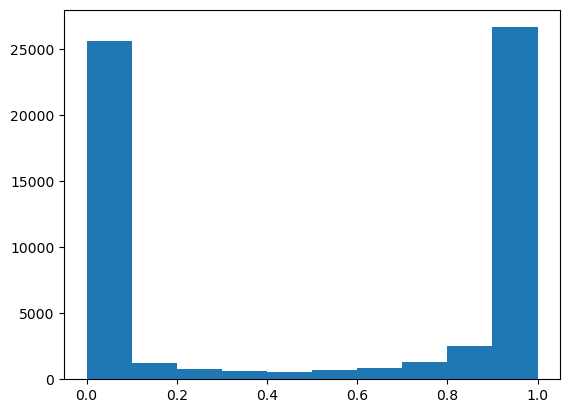

In [30]:
plt.hist(predictions)

In [31]:
np.where((predictions>0.9) | (predictions<0.1))

(array([    0,     1,     2, ..., 60859, 60860, 60861]),)

In [32]:
sum(test == edge_labels_test[np.where((predictions>0.5) | (predictions<0.5))])/len(test)

0.9618316847951103

In [33]:
len(test)/len(predictions)

1.0

In [34]:
model.save(f"./model/gbif_batch_{batch_size}_layer_{hinsage_layer_sizes[0]}_s_to_m")

INFO:tensorflow:Assets written to: ./model/gbif_batch_128_layer_1024_s_to_m/assets


INFO:tensorflow:Assets written to: ./model/gbif_batch_128_layer_1024_s_to_m/assets
